In [1]:
import torchOptics.optics as tt
import warnings
import torch.nn as nn
import torchOptics.metrics as tm
import torch.nn.functional as F
import torch.optim
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision
import datetime
import tqdm
import time
import HHS.model


warnings.filterwarnings('ignore')


class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        t = torch.Tensor([0.5]).cuda()  # threshold
        output = (input > t).float() * 1
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

class RealSign(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input


class Dataset512(Dataset):
    def __init__(self, target_dir, meta, transform=None, isTrain=True):
        self.target_dir = target_dir
        self.transform = transform
        self.meta = meta
        self.isTrain = isTrain
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        self.center_crop = torchvision.transforms.CenterCrop(512)
        self.random_crop = torchvision.transforms.RandomCrop((512, 512))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta)
        if self.isTrain:
            target = self.random_crop(target)
        else:
            target = self.center_crop(target)
        return target


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

# load data
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
valid_dir = 'dataset/DIV2K/DIV2K_valid_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
train_dataset = Dataset512(target_dir=target_dir, meta=meta, isTrain=True)
valid_dataset = Dataset512(target_dir=valid_dir, meta=meta, isTrain=False)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)


def train(model, num_hologram=10, custom_name='fcn', epochs=100, lr=1e-4, z=2e-3):
    date = datetime.datetime.now() - datetime.timedelta(hours=15)
    mean_psnr_list = []
    mean_mse_list = []
    max_epoch = 0
    max_psnr = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sign_function = SignFunction.apply
    # path = 'models/'
    model_name = f'{date}_{custom_name}_{num_hologram}_{z}'
    # make result folder
    result_folder = 'result/'+model_name
    os.mkdir(result_folder)
    model_path = os.path.join(result_folder, model_name)
    psnr_result_path = os.path.join(result_folder, 'meanPSNR.npy')
    mse_result_path = os.path.join(result_folder, 'meanMSE.npy')
    result = {'model_path': model_path, 'psnr_result_path': psnr_result_path,
          'mse_result_path': mse_result_path, 'z': z,
          'num_hologram': num_hologram, 'lr': lr, 'epochs': epochs}
    # save result dict
    with open(os.path.join(result_folder, 'result_dict.pickle'), 'wb') as fw:
        pickle.dump(result, fw)
    for epoch in range(epochs):
        pbar = tqdm.tqdm(trainloader)
        model.train()
        for target in pbar:
            out = model(target)
            binary = sign_function(out)
            sim = tt.simulate(binary, z).abs()**2
            result = torch.mean(sim, dim=1, keepdim=True)
            loss = tt.relativeLoss(result, target, F.mse_loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            psnrList = []
            mseList = []
            for valid in validloader:
                out = model(valid)
                binary = sign_function(out)
                sim = tt.simulate(binary, z).abs()**2
                result = torch.mean(sim, dim=1, keepdim=True)
                psnr = tt.relativeLoss(result, valid, tm.get_PSNR)
                psnrList.append(psnr)
                mse = tt.relativeLoss(result, valid, F.mse_loss).detach().cpu().numpy()
                mseList.append(mse)
            mean_psnr = sum(psnrList)/len(psnrList)
            mean_mse = sum(mseList)/len(mseList)
            mean_psnr_list.append(mean_psnr)
            mean_mse_list.append(mean_mse)
            # save psnr and mse
            np.save(psnr_result_path, mean_psnr_list)
            np.save(mse_result_path, mean_mse_list)
            plt.plot(np.arange(len(mean_psnr_list)), mean_psnr_list,
                     label=f'max psnr: {max(mean_psnr_list)}')
            plt.title(model_name+'_psnr')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanPSNR.png'))
            plt.clf()
            plt.plot(np.arange(len(mean_mse_list)), mean_mse_list,
                     label=f'max psnr: {min(mean_mse_list)}')
            plt.title(model_name+'_mse')
            plt.legend()
            plt.savefig(os.path.join(result_folder, 'meanMSE.png'))
            plt.clf()
            print(f'mean PSNR : {mean_psnr} {epoch}/{epochs}')
            print(f'mean MSE : {mean_mse} {epoch}/{epochs}')

        if mean_psnr > max_psnr:
            max_psnr = mean_psnr
            max_epoch = epoch
            torch.save(model.state_dict(), model_path)
        print(f'max_psnr: {max_psnr}, epoch: {max_epoch}')


def binary_sim(out, z=2e-3):
    binary = SignFunction.apply(out)
    sim = tt.simulate(binary, z).abs()**2
    res = torch.mean(sim, dim=1, keepdim=True)
    return binary, res


def valid(model):
    with torch.no_grad():
        psnr_list = []
        for target in validloader:
            out = model(target)
            binary, res = binary_sim(out)
            psnr = tt.relativeLoss(res, target, tm.get_PSNR)
            psnr_list.append(psnr)
    print(sum(psnr_list)/len(psnr_list))


def check_order(bmodel, classifier, target):
    if len(target.shape) == 3:
        target = target.unsqueeze(0)
    result = []
    with torch.no_grad():
        out = bmodel(target)
        binary, res = binary_sim(out)
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


def check_order_without_model(binary, classifier):
    with torch.no_grad():
        result = []
        for i in range(10):
            binary_input = binary[0][i].unsqueeze(0).unsqueeze(0)
            prop_order = classifier(binary_input)
            result.append(torch.argmax(prop_order))
    print(result)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(64 * 64 * 64, 10)  # 최종 분류를 위한 FC 레이어

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 64 * 64 * 64)  # flatten
        x = self.fc(x)
        return x


def rgb_binary_sim(out, z):
    meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
    rmeta = {'wl': (638e-9), 'dx': (6.3e-6, 6.3e-6)}
    gmeta = {'wl': (515e-9), 'dx': (6.3e-6, 6.3e-6)}
    bmeta = {'wl': (450e-9), 'dx': (6.3e-6, 6.3e-6)}
    sign = SignFunction.apply
    binary = sign(out)
    channel = out.shape[1]
    rchannel = int(channel/3)
    gchannel = int(channel*2/3)
    red = binary[:, :rchannel, :, :]
    green = binary[:, rchannel:gchannel, :, :]
    blue = binary[:, gchannel:, :, :]
    red = tt.Tensor(red, meta=rmeta)
    green = tt.Tensor(green, meta=gmeta)
    blue = tt.Tensor(blue, meta=bmeta)
    rsim = tt.simulate(red, z).abs()**2
    gsim = tt.simulate(green, z).abs()**2
    bsim = tt.simulate(blue, z).abs()**2
    rmean = torch.mean(rsim, dim=1, keepdim=True)
    gmean = torch.mean(gsim, dim=1, keepdim=True)
    bmean = torch.mean(bsim, dim=1, keepdim=True)
    rgb = torch.cat([rmean, gmean, bmean], dim=1)
    rgb = tt.Tensor(rgb, meta=meta)
    binary = tt.Tensor(binary, meta=meta)
    return binary, rgb

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


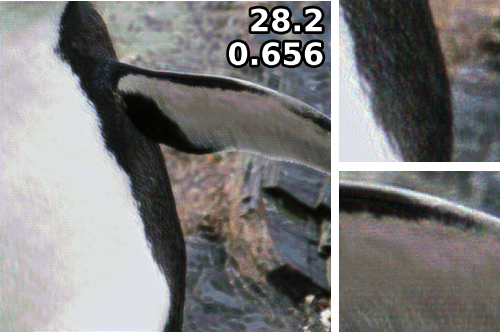

In [30]:
model = HHS.model.FCN_Leakey_4(24, 'Sigmoid', 24, [16, 32, 64, 128]).cuda()
pretrained = HHS.model.FCN_Leakey_4(24, 'Sigmoid', 3, [16, 32, 64, 128]).cuda()
pretrained.load_state_dict(torch.load('result/16/layer62024-05-14 15:54:55.920214_[16, 32, 64, 128]_24_24_0.002/2024-05-14 15:54:55.920214_[16, 32, 64, 128]_24_24_0.002'))
pretrained.eval()
dbs = 'dataset/dbs_DIV2L_valid/0000.npy'
dbs = np.load(dbs)
dbs = tt.Tensor(dbs, meta=meta).cuda()
target = valid_dataset[0].unsqueeze(0)
out = pretrained(target)
binary, sim = rgb_binary_sim(out, 2e-3)
binary = binary.detach()
crop = torchvision.transforms.CenterCrop(480)
crop_sim = crop(sim)
crop_target = crop(target)
tt.show_with_insets(crop_sim, crop_target, correct_colorwise=True)


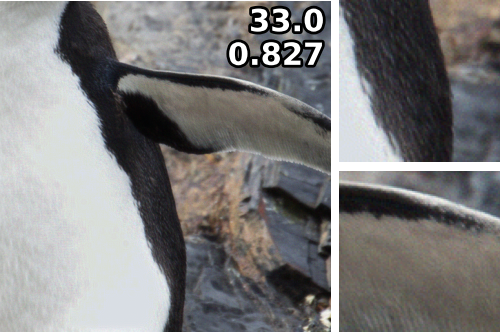

In [31]:
diff = dbs - binary
diff = diff.abs()

train_binary = binary.clone()
res = train_binary - diff
res = res.abs()
_, res = rgb_binary_sim(dbs, 2e-3)
tt.show_with_insets(crop(res), crop_target, correct_colorwise=True)

In [21]:
model = HHS.model.FCN_Leakey_4(24, 'Sigmoid', 24, [128, 256, 512, 1024]).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_list = []
psnr_list = []
mse_list = []
crop = torchvision.transforms.CenterCrop(480)
crop_target = crop(target)
sign = SignFunction.apply
for epoch in tqdm.tqdm(range(5000)):
    out = model(binary)
    out_diff = sign(out)
    diff_loss = F.mse_loss(out_diff, diff)
    binary_test = binary.clone()
    binary_test = (binary_test - out_diff).abs()
    _, sim = rgb_binary_sim(binary_test, 2e-3)
    crop_sim = crop(sim)
    img_loss = tt.relativeLoss(crop_sim, crop_target, F.mse_loss)
    psnr = tt.relativeLoss(crop_sim, crop_target, tm.get_PSNR)
    loss_list.append(diff_loss.detach().cpu())
    psnr_list.append(psnr)
    mse_list.append(img_loss.detach().cpu())
    optimizer.zero_grad()
    # tot_loss = diff_loss + img_loss
    tot_loss = diff_loss
    tot_loss.backward()
    optimizer.step()

100%|██████████| 5000/5000 [03:38<00:00, 22.93it/s]


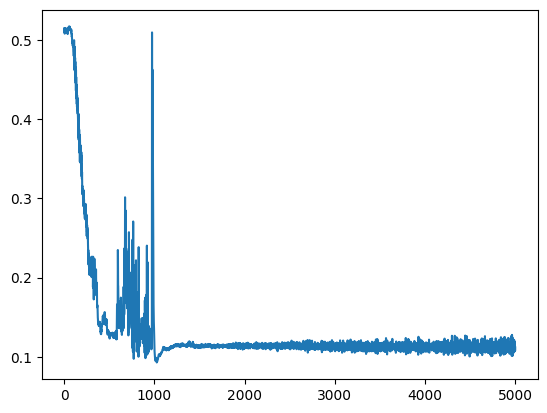

In [22]:
plt.plot(np.arange(len(loss_list)), loss_list)
plt.show()

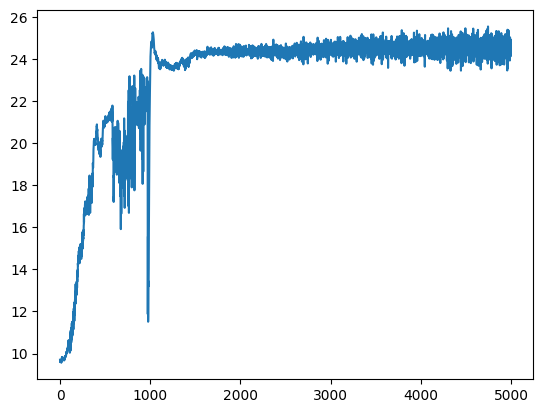

In [23]:
plt.plot(np.arange(len(psnr_list)), psnr_list)
plt.show()


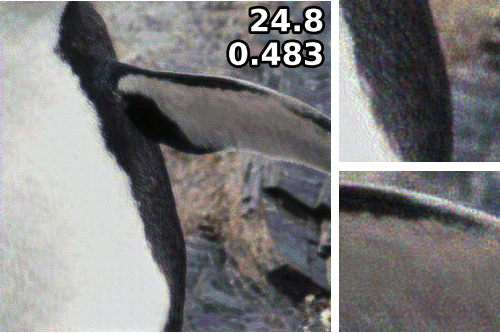

In [24]:
tt.show_with_insets(crop_sim, crop_target, correct_colorwise=True)